In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant, No Prefactor
def f(r,M,n,re):
     return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,n,re,load=True,path='../')**2 
                    + nf.d_v(r,load=True,path='../')**2)
    
#keeping others but holding them constant, Using Prefactor
def g(r,M,c):
     return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + c**2*nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,load=True,path='../')**2)
    
#Only Black Hole and Bulge, No Prefactor
def bh_b(r,M,n,re):
    return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 + nf.b_v(r,n,re,load=True,path='../')**2)

#Only Black Hole and Bulge, Using Prefactor
def bh_b2(r,M,c):
    return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 + c**2*nf.b_v(r,load=True,path='../')**2)

In [4]:
#Fit, Keeping rest constant, No Prefactor

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Black Hole
l_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
l_params.add('n', value=nf.n_c, min=0) 
l_params.add('re', value=nf.re_c, min=0)
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

../../python/NGC5533_functions.py:231: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return si.quad(h, 0, r, args=(r,n,re))[0]
../../python/NGC5533_functions.py:231: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return si.quad(h, 0, r, args=(r,n,re))[0]
../../python/NGC5533_functions.py:225: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return si.quad(f, m, np.inf,args=(m,n,re))[0]


In [5]:
#Fit, Keeping rest constant, Using Prefactor

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
g_params.add('c', value=1, min=0) 
#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [6]:
#Fit, BH and B Only, No Prefactor

#Setup
bhb_mod = lm.Model(bh_b)
bhb_params = bhb_mod.make_params()
#Black Hole
bhb_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
bhb_params.add('n', value=nf.n_c, min=0) 
bhb_params.add('re', value=nf.re_c, min=0)
#Do fit
bhb_fit = bhb_mod.fit(v_dat,bhb_params,r=r_dat,weights=weighdata)

In [7]:
#Fit, BH and B Only, Using Prefactor

#Setup
bhb2_mod = lm.Model(bh_b2)
bhb2_params = bhb2_mod.make_params()
#Black Hole
bhb2_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
bhb2_params.add('c', value=1, min=0) 
#Do fit
bhb2_fit = bhb2_mod.fit(v_dat,bhb2_params,r=r_dat,weights=weighdata)

In [8]:
#Define curves to plot

l_dict = l_fit.best_values
l_M = l_dict['M']
l_n = l_dict['n']
l_re = l_dict['re']
l_curve = f(r_dat,l_M,l_n,l_re)

g_dict = g_fit.best_values
g_M = g_dict['M']
g_c = g_dict['c']
g_curve = g(r_dat,g_M,g_c)

bhb_dict = bhb_fit.best_values
bhb_M = bhb_dict['M']
bhb_n = bhb_dict['n']
bhb_re = bhb_dict['re']

bhb2_dict = bhb2_fit.best_values
bhb2_M = bhb2_dict['M']
bhb2_c = bhb2_dict['c']

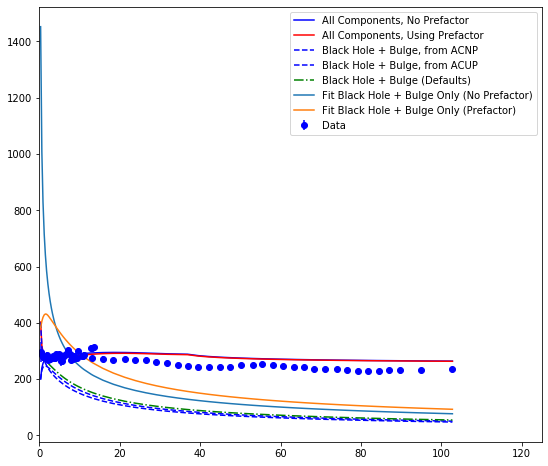

In [9]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, No Prefactor')
plt.plot(r_dat,g_curve,'r-',label='All Components, Using Prefactor')
plt.plot(r_dat,bh_b(r_dat,l_M,l_n,l_re),'b--',label='Black Hole + Bulge, from ACNP')
plt.plot(r_dat,bh_b2(r_dat,g_M,g_c),'b--',label='Black Hole + Bulge, from ACUP')
plt.plot(r_dat,bh_b(r_dat,nf.Mbh_def,nf.n_c,nf.re_c),'g-.',label='Black Hole + Bulge (Defaults)')
plt.plot(r_dat,bh_b(r_dat,bhb_M,bhb_n,bhb_re),label='Fit Black Hole + Bulge Only (No Prefactor)')
plt.plot(r_dat,bh_b2(r_dat,bhb2_M,bhb2_c),label='Fit Black Hole + Bulge Only (Prefactor)')

plt.legend()
plt.show()

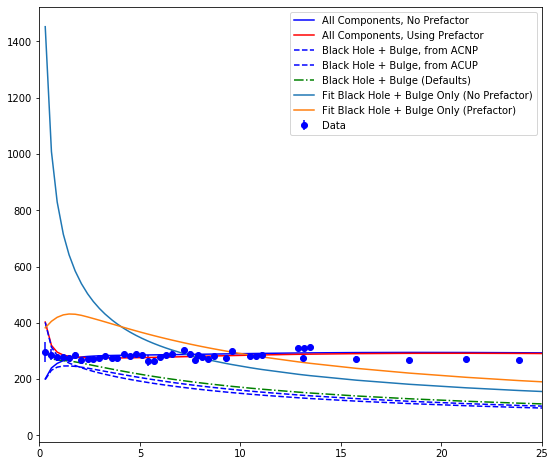

In [10]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, No Prefactor')
plt.plot(r_dat,g_curve,'r-',label='All Components, Using Prefactor')
plt.plot(r_dat,bh_b(r_dat,l_M,l_n,l_re),'b--',label='Black Hole + Bulge, from ACNP')
plt.plot(r_dat,bh_b2(r_dat,g_M,g_c),'b--',label='Black Hole + Bulge, from ACUP')
plt.plot(r_dat,bh_b(r_dat,nf.Mbh_def,nf.n_c,nf.re_c),'g-.',label='Black Hole + Bulge (Defaults)')
plt.plot(r_dat,bh_b(r_dat,bhb_M,bhb_n,bhb_re),label='Fit Black Hole + Bulge Only (No Prefactor)')
plt.plot(r_dat,bh_b2(r_dat,bhb2_M,bhb2_c),label='Fit Black Hole + Bulge Only (Prefactor)')


plt.legend()
plt.show()

In [11]:
print('Fit information for all-component fit (no prefactor):')
l_fit

Fit information for all-component fit (no prefactor):


In [12]:
print('Fit information for all-component fit (using prefactor):')
g_fit

Fit information for all-component fit (using prefactor):


In [13]:
print('Fit information for two-component fit (no prefactor):')
bhb_fit

Fit information for two-component fit (no prefactor):


In [14]:
print('Fit information for two-component fit (using prefactor):')
bhb2_fit

Fit information for two-component fit (using prefactor):


In [15]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
9027.510467529297 seconds

Timestamp:
2020-03-19 00:55:20.684622
